# Question 1

In [1]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print(f'func: {f.__name__} took: {te-ts:.4f} sec')
        return result

    return timed

In [2]:
def load_dataset(path):
    with open(path, 'rb') as f:
        train_data, test_data = pickle.load(f)
    
    X_train = torch.tensor(train_data[0], dtype=torch.float)
    y_train = torch.tensor(train_data[1], dtype=torch.long)
    X_test = torch.tensor(test_data[0], dtype=torch.float)
    y_test = torch.tensor(test_data[1], dtype=torch.long)
    return X_train, y_train, X_test, y_test

In [3]:
X_train, y_train, X_test, y_test = load_dataset("Datasets/mnist.pkl")

print("X_train shape:", X_train.shape[0])
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: 60000
X_test shape: torch.Size([10000, 32, 32])
y_train shape: torch.Size([60000])
y_test shape: torch.Size([10000])


In [4]:
class MnistDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA available")
else:
    device = torch.device("cpu")

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

## (a)

In [6]:
X_train = X_train.reshape(X_train.shape[0], -1) / torch.max(X_train)
X_test = X_test.reshape(X_test.shape[0], -1) / torch.max(X_test)
print(X_train.shape)

train_data = MnistDataset(X_train, y_train)
test_data = MnistDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

torch.Size([60000, 1024])


## (b)

**Complete the following Python class for training/evaluation**

In [7]:
class Trainer:
    
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2):
        self.model = model
        # calulate the number of parameters
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        if opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        elif opt_method == "sgdm":
            # Hint: to use SGDM in PyTorch, use torch.optim.SGD and set momentum to a non-zero value
            self.optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
    
    @timeit
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        train_loss_list, train_acc_list = [], []
        val_loss_list, val_acc_list = [], []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        loss_func = nn.CrossEntropyLoss()
        for n in tqdm(range(self.epoch), leave=False):
            # enable train mode
            self.model.train()
            for X_batch, y_batch in train_loader:
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
            
            # call the evaluate function
            train_loss, train_acc = self.evaluate(train_data)
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            
            val_loss, val_acc = self.evaluate(val_data)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].plot(x_axis, val_loss_list, label="Validation")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_acc_list, label='Train')
            axes[1].plot(x_axis, val_acc_list, label='Validation')
            axes[1].set_title("Accuracy")
            axes[1].legend()
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "train_acc_list": train_acc_list,
            "val_loss_list": val_loss_list,
            "val_acc_list": val_acc_list,
        }
    
    def evaluate(self, data, print_acc=False):
        # enable evaluation mode
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size, shuffle=True)
        loss_func = nn.CrossEntropyLoss()
        acc, loss = 0.0, 0.0
        for X_batch, y_batch in loader:
            with torch.no_grad():
                batch_importance = y_batch.shape[0] / len(data)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                batch_acc = torch.sum(torch.argmax(y_pred, axis=1) == y_batch) / y_batch.shape[0]
                acc += batch_acc.detach().cpu().item() * batch_importance
                loss += batch_loss.detach().cpu().item() * batch_importance
        if print_acc:
            print(f"Accuracy: {acc:.3f}")
        return loss, acc
            
            

**Complete the following function to do KFold cross validation**

In [8]:
def KFoldCrossValidation(
    model_class, k, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', learning_rate=2e-3, batch_size=128, epoch=50, l2=0.0
):
    # Use MnistDataset to organize data
    test_data = MnistDataset(X_test, y_test)
    kf = KFold(3)
    train_acc_list, test_acc_list = [], []
    for i, (train_index, val_index) in enumerate(kf.split(X_train)):
        print(f"Fold {i}:")
        
        # Use MnistDataset to organize data
        train_data = MnistDataset(X_train[train_index], y_train[train_index])
        val_data = MnistDataset(X_train[val_index], y_train[val_index])
        
        model = model_class
        # initialize a Trainer object
        trainer = Trainer(model_class, opt_method, learning_rate, batch_size, epoch, l2)
        # call trainer.train() here
        res = trainer.train(train_data, val_data)
        # record the training accuracy of the epoch that has the lowest valiation lost
        # Hint: use np.argmin
        train_acc_best = res["val_acc_list"][np.argmin(res["val_loss_list"])]
        # test, use trainer.evaluate function
        test_loss, test_acc = trainer.evaluate(test_data)
        
        train_acc_list.append(train_acc_best)
        test_acc_list.append(test_acc)
        
        print(f"Training accuracy: {train_acc_best}")
        print(f"Test accuracy: {test_acc}")
    
    print("Final results:")
    # Report mean and std
    print(f"Training accuracy:", "Mean:", np.mean(train_acc_list), "Std:", np.std(train_acc_list))
    print(f"Test accuracy:", "Mean:", np.mean(test_acc_list), "Std:", np.std(test_acc_list))

## (c)

In [9]:
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024, 3),
            nn.Sigmoid(),
            nn.Linear(3, 10),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

Fold 0:
Net3 - Number of parameters: 3115


func: train took: 18.9735 sec
Training accuracy: 0.5479999999999999
Test accuracy: 0.5529999999999996
Fold 1:
Net3 - Number of parameters: 3115


func: train took: 18.4582 sec
Training accuracy: 0.6002500000000001
Test accuracy: 0.6013999999999999
Fold 2:
Net3 - Number of parameters: 3115


func: train took: 17.8218 sec
Training accuracy: 0.61295
Test accuracy: 0.6007999999999999
Final results:
Training accuracy: Mean: 0.5870666666666667 Std: 0.02810665203984443
Test accuracy: Mean: 0.5850666666666665 Std: 0.022675880480271592


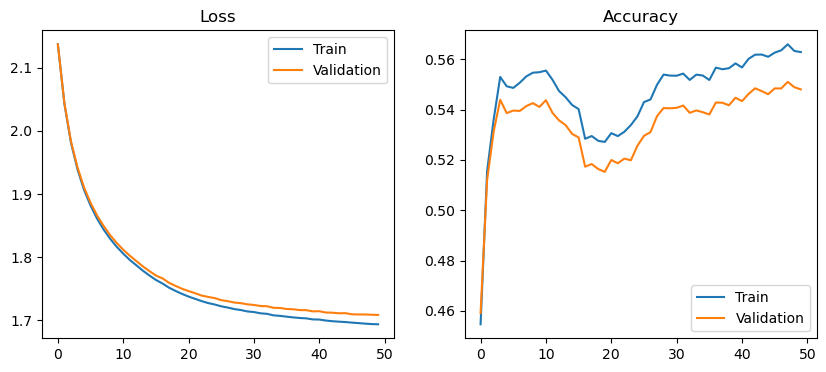

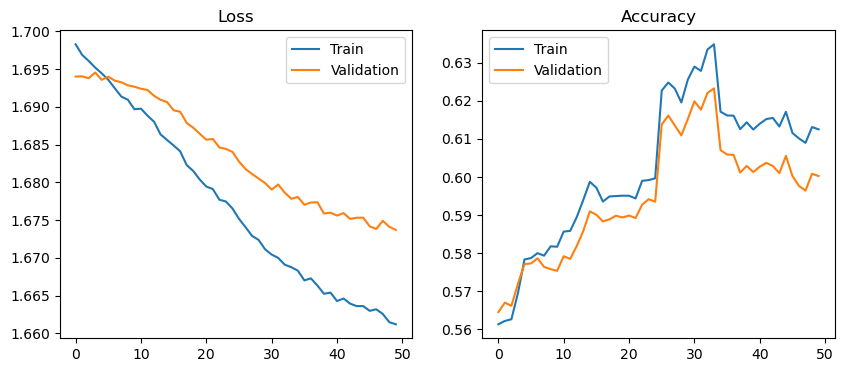

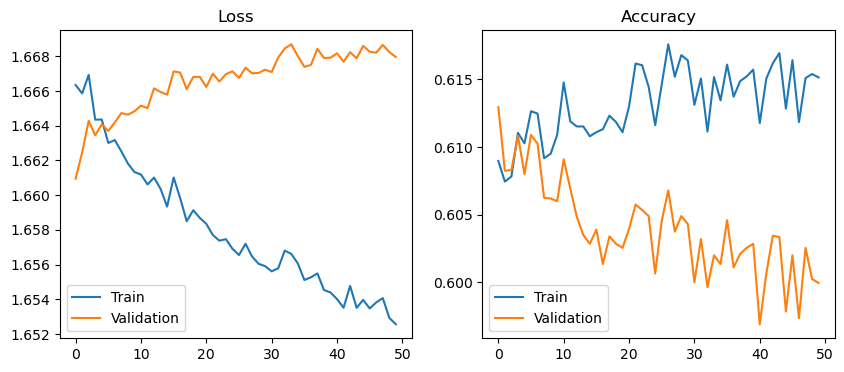

In [10]:
KFoldCrossValidation(Net3().to(device), 3, X_train, y_train, X_test, y_test)

# (c)
### There is a lot of bias in this model.  We can see that the model is underfitting because of high bias.  First, our training and validation loss are high, which means that our model is not learning.  Three neurons is not sufficient enough to capture the problem space.  Second, our training and validation losses are close to each other.  We are making assumptions about the validation loss that are highly influenced by our training data.  We have high bias and low variance.  To do this, we should increase the complexity of our hidden layer.

## (d)

In [11]:
class Net50(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024, 50),
            nn.Sigmoid(),
            nn.Linear(50, 10),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

Fold 0:
Net50 - Number of parameters: 51760


  0%|          | 0/50 [00:00<?, ?it/s]

func: train took: 21.5050 sec
Training accuracy: 0.9539999999999994
Test accuracy: 0.9578999999999996
Fold 1:
Net50 - Number of parameters: 51760


func: train took: 21.0474 sec
Training accuracy: 0.9803999999999979
Test accuracy: 0.9629999999999995
Fold 2:
Net50 - Number of parameters: 51760


func: train took: 21.0169 sec
Training accuracy: 0.9873499999999981
Test accuracy: 0.9639999999999994
Final results:
Training accuracy: Mean: 0.9739166666666651 Std: 0.014366183286531043
Test accuracy: Mean: 0.9616333333333329 Std: 0.0026712460679531357


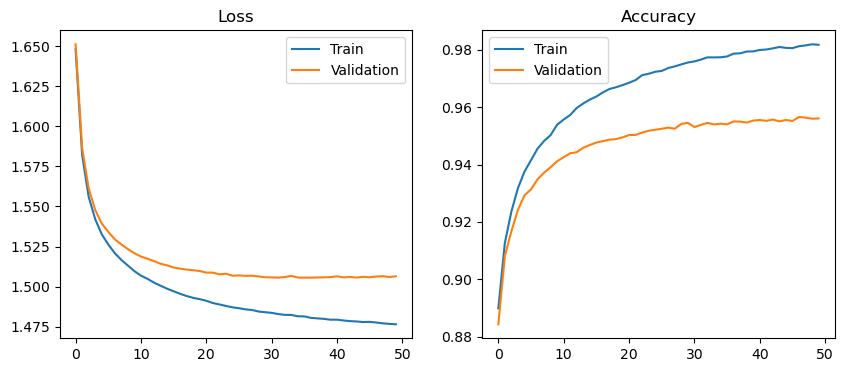

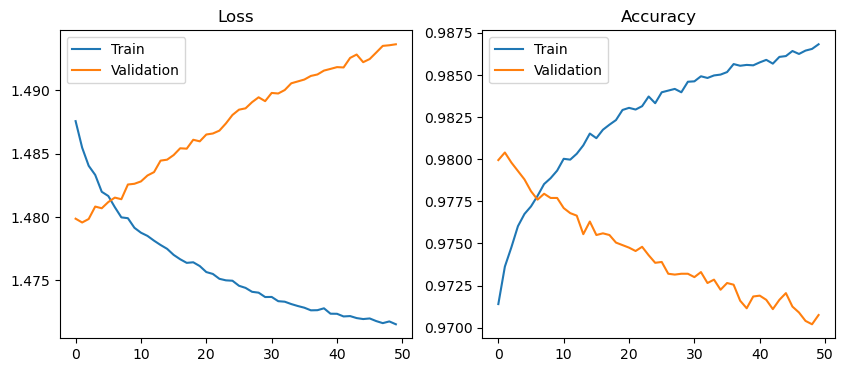

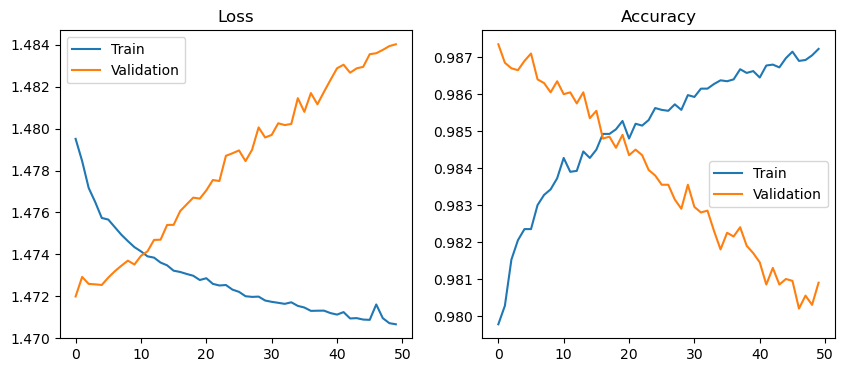

In [12]:
KFoldCrossValidation(Net50().to(device), 3, X_train, y_train, X_test, y_test)

# (d)
### Looking at the first graph gives us an indication that we are now overfitting.  We see that there is a major gap between the validation loss and the training loss. Our model continues to converge on the training data, but our validation loss increases.  There is high variance and low bias between assumptions of our training and testing data.  High variance models is a general sign that we are overfitting.  We also know that adding neurons to our hidden layer can easily result in an overfitting scenario.  Dropout would help solve this issue.

# Question 2

## (a)

In [13]:
class Net50Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024, 50),
            nn.Sigmoid(),
            nn.Linear(50, 10),
            nn.Sigmoid(),
            nn.Dropout(p=0.15),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

Fold 0:
Net50Dropout - Number of parameters: 51760


  0%|          | 0/50 [00:00<?, ?it/s]

func: train took: 21.4076 sec
Training accuracy: 0.9528999999999994
Test accuracy: 0.9537999999999995
Fold 1:
Net50Dropout - Number of parameters: 51760


func: train took: 21.1884 sec
Training accuracy: 0.9776999999999981
Test accuracy: 0.9606999999999994
Fold 2:
Net50Dropout - Number of parameters: 51760


func: train took: 21.4474 sec
Training accuracy: 0.982849999999998
Test accuracy: 0.9595999999999993
Final results:
Training accuracy: Mean: 0.9711499999999985 Std: 0.013074848628823587
Test accuracy: Mean: 0.9580333333333328 Std: 0.0030269162892656697


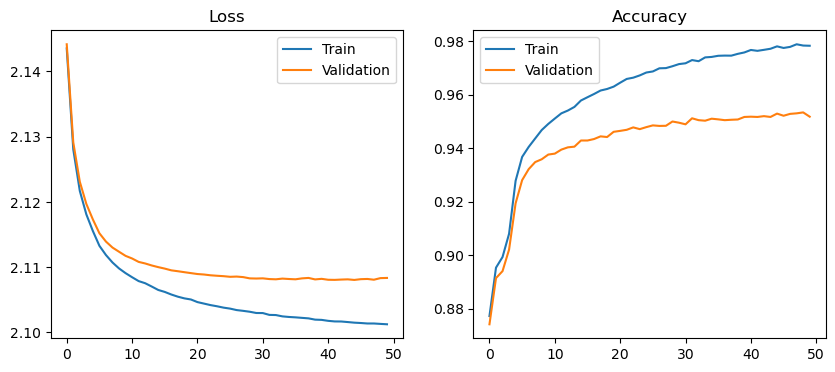

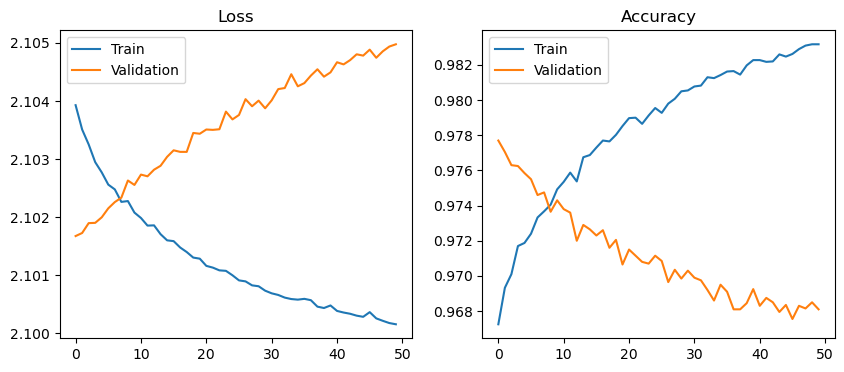

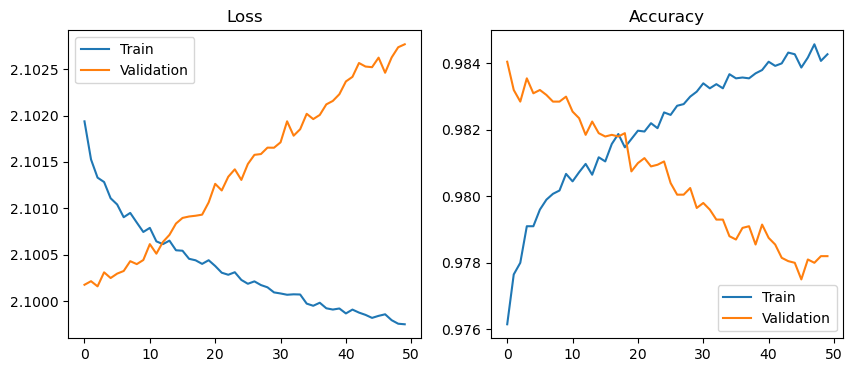

In [14]:
KFoldCrossValidation(Net50Dropout().to(device), 3, X_train, y_train, X_test, y_test)

# (a)
### There is a small increase in accuracy between our dropout model and 1d.  Both are around 95%.  There is less variance and more bias between our training and validation loss.  Our validation loss does not increase as much as before.  We are introducing more bias, and we can see that the validation loss no longer increases.  This likely means that we are overfitting less.  This is a good tradeoff - we want to increase our bias and lower our variance from the model in 1d, so that we overfit less.  This is an improvement over 1d.  The validation accuracy decreases at a slower rate vs. the training accuracy.

## (b)

Fold 0:
Net50 - Number of parameters: 51760


  0%|          | 0/50 [00:00<?, ?it/s]

func: train took: 21.5141 sec
Training accuracy: 0.9619499999999986
Test accuracy: 0.9649999999999991
Fold 1:
Net50 - Number of parameters: 51760


func: train took: 20.9561 sec
Training accuracy: 0.9785999999999981
Test accuracy: 0.9704999999999995
Fold 2:
Net50 - Number of parameters: 51760


func: train took: 22.2555 sec
Training accuracy: 0.984999999999998
Test accuracy: 0.9709999999999993
Final results:
Training accuracy: Mean: 0.9751833333333316 Std: 0.009715308652956778
Test accuracy: Mean: 0.9688333333333325 Std: 0.0027182510717168227


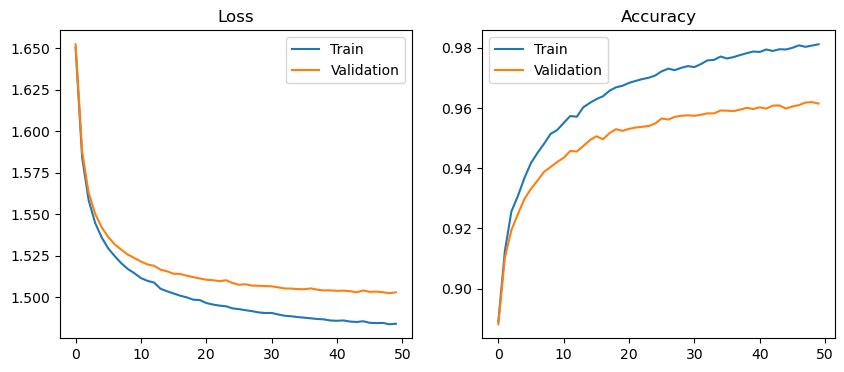

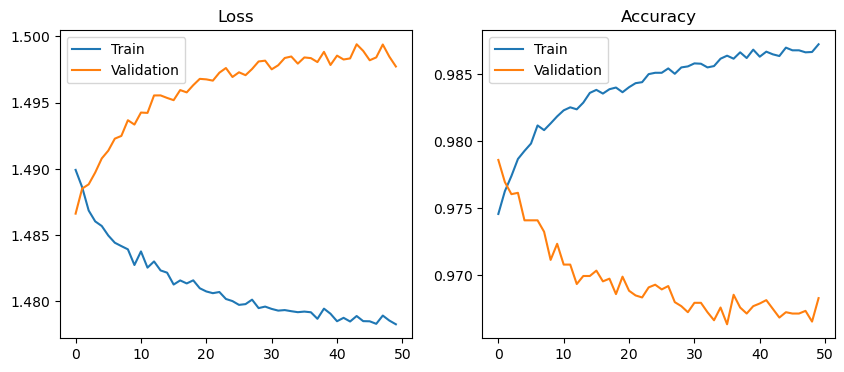

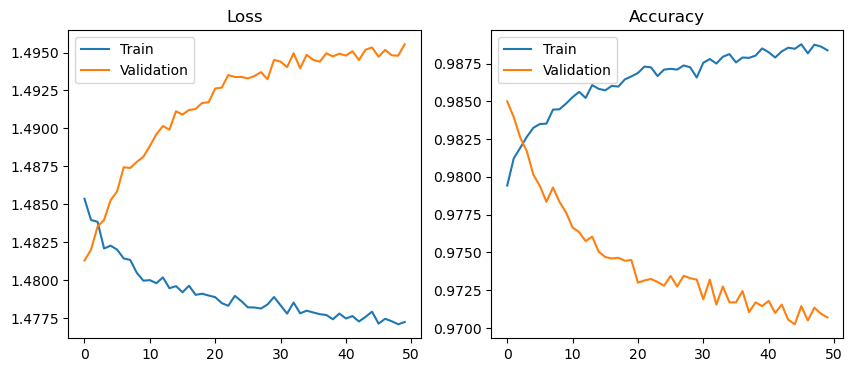

In [15]:
# L2 Regularizaiton by setting the "l2" parameter in KFoldCrossValidation
KFoldCrossValidation(Net50().to(device), 3, X_train, y_train, X_test, y_test, l2=1e-5)

# (b)
### Regularization shows that we are also reducing overfitting now.  It helps our accuracy a tiny bit, but we have already achieved an accuracy above 90%, so the gains are minimal.  It looks like L2 regularization reduces our variance.  Validation loss plateaus and training loss decreases. I would say that we have reduced our variance in turn for more bias (less overfitting).  Accuracy is also an improvement over 1d.  Validation accuracy starts to plateau.

## (c)

*For debugging*: You should get 331 features.

In [16]:
X_train = X_train.to("cpu")
X_test = X_test.to("cpu")

In [17]:
from sklearn.decomposition import PCA


pca = PCA(n_components=0.99)
# fit
pca.fit(X_train)
# transform

PCA(n_components=0.99)

In [18]:
X_train_pca = torch.from_numpy(pca.transform(X_train))
X_test_pca = torch.from_numpy(pca.transform(X_test))
X_train_pca, X_test_pca = X_train_pca.type(torch.float), X_test_pca.type(torch.float)
print(X_train_pca.shape, X_test_pca.shape)
assert X_train_pca.shape[1] == 331 and X_test_pca.shape[1] == 331, "wrong"

torch.Size([60000, 331]) torch.Size([10000, 331])


In [19]:
# Use one hidden layer of size 50, no Dropouts
class Net50PCA(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(331, 50),
            nn.Sigmoid(),
            nn.Linear(50, 10),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

In [20]:
X_train_pca = X_train_pca.to(device)
X_test_pca = X_test_pca.to(device)

Fold 0:
Net50PCA - Number of parameters: 17110


func: train took: 17.5498 sec
Training accuracy: 0.9469
Test accuracy: 0.9518999999999996
Fold 1:
Net50PCA - Number of parameters: 17110


func: train took: 17.5812 sec
Training accuracy: 0.978449999999998
Test accuracy: 0.9530999999999995
Fold 2:
Net50PCA - Number of parameters: 17110


func: train took: 17.4271 sec
Training accuracy: 0.9844499999999978
Test accuracy: 0.9544999999999995
Final results:
Training accuracy: Mean: 0.9699333333333321 Std: 0.016470191930338596
Test accuracy: Mean: 0.9531666666666663 Std: 0.001062491830033878


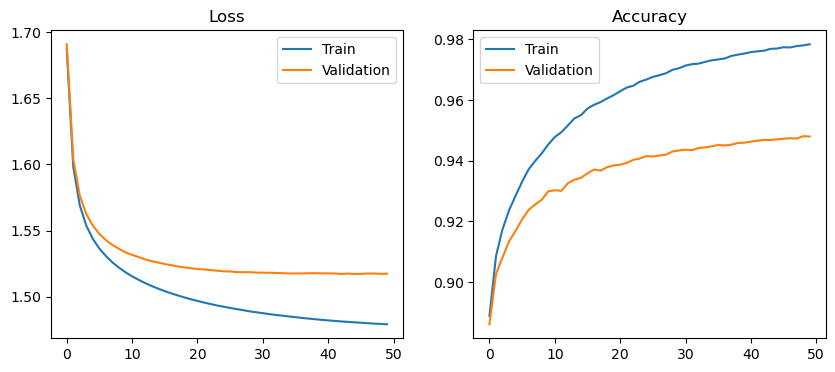

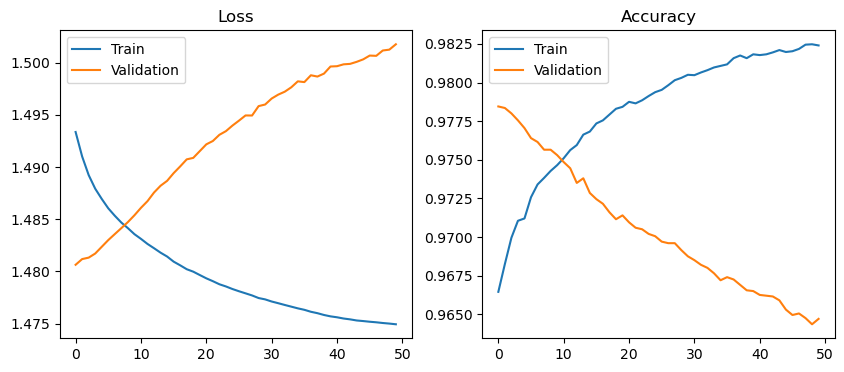

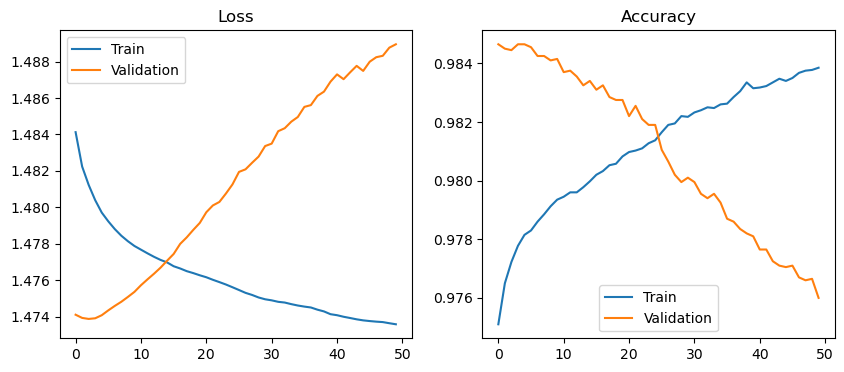

In [21]:
KFoldCrossValidation(Net50PCA().to(device), 3, X_train_pca, y_train, X_test_pca, y_test)

# (c)
### PCA regularization is also helping to reduce overfitting, but not by that much.  We need to add another technique to reduce the increase in validation loss.  We are still slightly overfitting, which means a high variance and low bias.  Nonetheless, using PCA fit on our data is an improvement on accuracy too.  We have 331 features now, instead of 1024.  PCA transformation should increase the efficiency of our model, which means we also have fewer parameters.  Validation accuracy is decreasing too fast.

## (d)

In [22]:
# If you find Dropout is better, finish this Net50PCADropout and do K-Fold CrossValidation

# class Net50PCADropout(nn.Module):
#     def __init__(self):
#         super().__init__()
#         ...
    
#     def forward(self, x):
#         return ...

Fold 0:
Net50PCA - Number of parameters: 17110


func: train took: 18.6096 sec
Training accuracy: 0.9543499999999991
Test accuracy: 0.9580999999999992
Fold 1:
Net50PCA - Number of parameters: 17110


func: train took: 18.0089 sec
Training accuracy: 0.972799999999998
Test accuracy: 0.9644999999999991
Fold 2:
Net50PCA - Number of parameters: 17110


func: train took: 18.9857 sec
Training accuracy: 0.9828999999999979
Test accuracy: 0.9694999999999991
Final results:
Training accuracy: Mean: 0.9700166666666649 Std: 0.011820485983616577
Test accuracy: Mean: 0.9640333333333325 Std: 0.004665714188512703


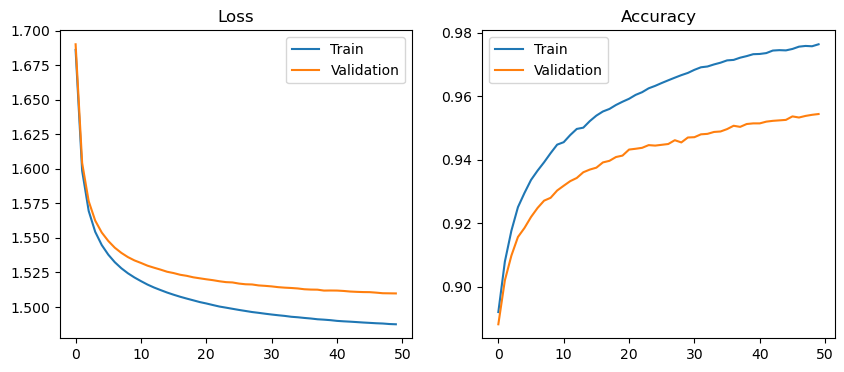

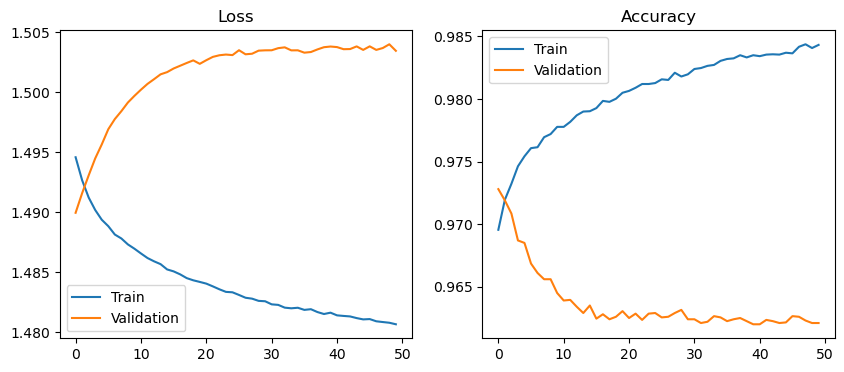

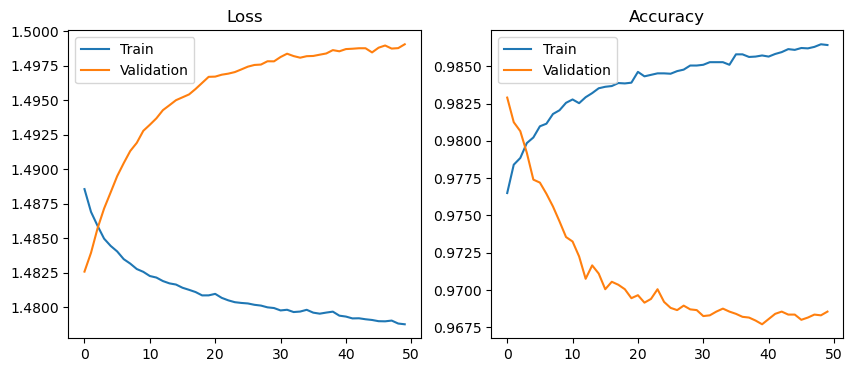

In [23]:
# If you find L2 Regularization is better, 
# just call KFoldCrossValidation with Net50PCA and l2 set to non-zeros

KFoldCrossValidation(Net50PCA(), 3, X_train_pca, y_train, X_test_pca, y_test, l2=1e-5)

# (d)
### We now combine PCA transformation with one of the other methods to truly reduce overfitting.  I believe that L2 regularization was better at reducing overfitting from 1d.  Validation loss plateaus while training loss almost converges, which means that our solution has helped reduce overfitting successfully.  The training is not faster when using PCA vs. non-PCA data for this homework, but I know that in theory, PCA regularization should be faster because we reduce noise and irrelevant features.  There are fewer spikes on our loss graph, which also shows increased model stability when combining PCA and L2.  Validation accuracy is completely plateau now, which is a success.  This model works.